# Network Training
Having implemented and tested all the components of the final networks in steps 1-3, we are now ready to train the network on a large dataset (ImageNet).

In [64]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = "C:/Users/Trinh/Documents/Kaggle/Kaggle-imagenet/input/DET/train/ILSVRC2013_train"
TEST_DIR = "C:/Users/Trinh/Documents/Kaggle/Kaggle-imagenet/input/DET/rain/"
VAL_DIR = "C:/Users/Trinh/Documents/Kaggle/Kaggle-imagenet/input/DET/val/val_100/"

BATCH_SIZE = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating train & test data generator

In [65]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
    def flow_from_directory_for_test(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            
            # Get augmentend image samples
            ori = next(generator)

            # Get masks for each image sample
            # mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)
            
            image_mask = cv2.imread("C:/Users/Trinh/Documents/Kaggle/Kaggle-imagenet/input/DET/mask/mask.jpg")
            image_mask = cv2.resize(image_mask,(640,640))
            image_mask[image_mask <=128] = 128
            image_mask[image_mask > 128] = 0
            image_mask[image_mask > 0] = 255
            
            
            mask = np.stack([image_mask for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask==0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori
            
# Create training generator
train_datagen = DataGenerator(  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    horizontal_flip=True
)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=(640, 640), batch_size=BATCH_SIZE
)

# Create validation generator
val_datagen = DataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=(640, 640), batch_size=BATCH_SIZE, seed=1
)

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory_for_test(
    TEST_DIR, target_size=(640, 640), batch_size=BATCH_SIZE, seed=1
)


In [66]:
image_mask = cv2.imread("C:/Users/Trinh/Documents/Kaggle/Kaggle-imagenet/input/DET/mask/mask.jpg")
TEST_DIR

'C:/Users/Trinh/Documents/Kaggle/Kaggle-imagenet/input/DET/rain/'

Found 14 images belonging to 1 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


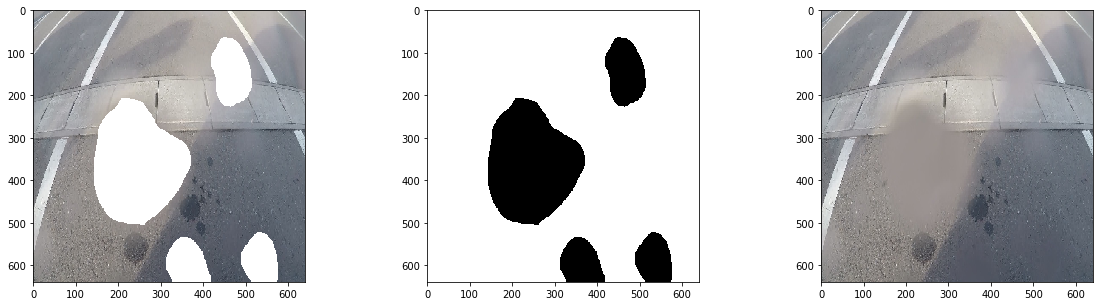

In [67]:
# Pick out an example
test_data = next(test_generator)
(masked, mask), ori = test_data

# Show side by side
for i in range(len(ori)):
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(masked[i,:,:,:])
    axes[1].imshow(mask[i,:,:,:] * 1.)
    axes[2].imshow(ori[i,:,:,:])
    plt.show()

# Training on ImageNet

In [68]:
def plot_callback(model):
    """Called at the end of each epoch, displaying our previous test images,
    as well as their masked predictions and saving them to disk"""
    
    # Get samples & Display them        
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 3, figsize=(20, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[2].imshow(ori[i,:,:,:])
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[2].set_title('Original Image')
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()

## Phase 1 - with batch normalization

In [69]:
# Instantiate the model
# model = PConvUnet(weight_filepath='data/logs/')
# model.load(r"C:\Users\MAFG\Documents\Github-Public\PConv-Keras\data\logs\50_weights_2018-06-01-16-41-43.h5")

model = PConvUnet(weight_filepath='data/logs/phase1')

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concat axis. Got inputs shapes: [(None, 5, 5, 640), (None, 6, 6, 640)]

In [49]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=1,
    validation_data=val_generator,
    validation_steps=1,
    epochs=1,        
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='data/logs/initial_training', write_graph=False)
    ]
)

Epoch 1/1
Found 498 images belonging to 3 classes.
Found 84 images belonging to 1 classes.
1/1 [==============================] - 77s 77s/step - loss: 3196512.0000 - val_loss: 3216099.5000


ValueError: Error when checking input: expected input_41 to have shape (512, 512, 3) but got array with shape (1024, 1024, 3)

## Phase 2 - without batch normalization

In [12]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/phase2/')
model.load(
    "data/logs/phase1/9_weights_2018-07-11-14-17-32.h5",
    train_bn=False,
    lr=0.00005
)

In [13]:
# Run training for certain amount of epochs
model.fit(
    train_generator, 
    steps_per_epoch=100,
    validation_data=val_generator,
    validation_steps=10,
    epochs=2,        
    workers=3,
    plot_callback=plot_callback,
    callbacks=[
        TensorBoard(log_dir='data/logs/fine_tuning', write_graph=False)
    ]
)

Epoch 10/10
100/100 [==============================] - ETA: 30:14 - loss: 1424213.00 - ETA: 26:51 - loss: 1415914.00 - ETA: 25:43 - loss: 1451925.91 - ETA: 25:04 - loss: 1458462.28 - ETA: 24:15 - loss: 1504655.22 - ETA: 23:35 - loss: 1552742.10 - ETA: 23:06 - loss: 1654725.44 - ETA: 22:44 - loss: 1781755.73 - ETA: 22:27 - loss: 1858380.23 - ETA: 22:03 - loss: 1814623.96 - ETA: 21:42 - loss: 1765676.02 - ETA: 21:21 - loss: 1766153.11 - ETA: 21:10 - loss: 1731032.30 - ETA: 20:59 - loss: 1764784.96 - ETA: 20:41 - loss: 1748214.85 - ETA: 20:24 - loss: 1741506.39 - ETA: 20:06 - loss: 1732232.76 - ETA: 19:48 - loss: 1703351.83 - ETA: 19:31 - loss: 1683472.24 - ETA: 19:14 - loss: 1691175.94 - ETA: 18:57 - loss: 1675348.20 - ETA: 18:43 - loss: 1664472.82 - ETA: 18:28 - loss: 1666824.39 - ETA: 18:15 - loss: 1681058.81 - ETA: 18:02 - loss: 1682039.48 - ETA: 17:47 - loss: 1674656.57 - ETA: 17:32 - loss: 1669909.55 - ETA: 17:17 - loss: 1700722.87 - ETA: 17:02 - loss: 1700324.23 - ETA: 16:45 - loss

## Phase 3 - Generating samples

In [18]:
# Load weights from previous run
model = PConvUnet(weight_filepath='data/logs/phase3')
model.load(
    "data/logs/phase2/11_weights_2018-07-11-15-12-15.h5",
    train_bn=False,
    lr=0.00005
)

In [48]:
n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'data/test_samples/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    # if n > 100:
        # break
    if n > 5:
        break

0it [00:00, ?it/s]


ValueError: Error when checking input: expected input_41 to have shape (512, 512, 3) but got array with shape (1024, 1024, 3)